## Training SNNs on temporal sequence MNIST data using SNNTorch network formulation

In [30]:
import os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime
import matplotlib.animation

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import snntorch as snn

In [13]:
# Setting random seeds
torch.manual_seed(0)
np.random.seed(0)

#### Load the produced MNIST sequences into torch's Dataset and DataLoader

In [14]:
dataset_sampling_frequency = 10
ingest_torch_dtype = torch.uint8
ingest_numpy_dtype = np.uint8

batch_size = 20

LIF_linear_features = 28*28
# LIF_linear_features = 1024
tao_mem = 0.01 # 10ms membrane time constant
timestep = 1/dataset_sampling_frequency
beta = np.exp(-timestep / tao_mem)
reset_mechanism = 'subtract'
init_type = 'pretrained'

dtype = torch.float32
device = torch.device('cuda')
num_workers = 36

In [15]:
weights_save_path=Path.home()/f'RANCZLAB-NAS/iakov/produced/mnist_sequence_checkpoints'/f'sequences_{dataset_sampling_frequency}hz_{int(LIF_linear_features)}x{int(LIF_linear_features)}_matrix_class_{init_type}_{reset_mechanism}_reset_beta_{beta:.2f}'

In [16]:
class NormaliseToZeroOneRange():
    def __init__(self, divide_by=255, dtype=torch.float16):
        self.divide_by = divide_by
        self.dtype = dtype
    def __call__(self, tensor):
        return (tensor / self.divide_by).to(self.dtype)

In [17]:
class MNISTSequencesDataset(Dataset):

    def __init__(self, file_path, transform=None):
        """
        Arguments:
            file_path (string): Path to the npy file with sequences.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = np.load(file_path, mmap_mode='r')
        self.transform = transform

    def perform_conversion(self, data):
        if LIF_linear_features == 1024: # Unsure how well this will work with passive memmap loading
            # Zero padding data to 32x32
            data_aug = np.zeros((data.shape[0], data.shape[1], 32, 32), dtype=ingest_numpy_dtype)
            data_aug[:,:,:28,:28] = data
            data = data_aug.copy()
            del data_aug
        # data = data.reshape((data.shape[0], data.shape[1], data.shape[2]*data.shape[3]))
        data = data.reshape((-1, data.shape[-2]*data.shape[-1]))
        data = torch.tensor(data, dtype=ingest_torch_dtype)
        return data
    
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        sample = self.data[idx]
        sample = self.perform_conversion(sample)

        if self.transform:
            sample = self.transform(sample)

        return sample

In [18]:
dataset_path = Path.home()/f'RANCZLAB-NAS/iakov/produced/'
# dataset_path = Path.home()/'disk2/'
dataset_file = f'mnist_sequences_{dataset_sampling_frequency}hz.npy'

normalise_transform = NormaliseToZeroOneRange(dtype=dtype)
mnist_dataset = MNISTSequencesDataset(dataset_path/dataset_file, transform=normalise_transform)
train_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [20]:
batch_data_shape = next(iter(train_loader)).shape
print(batch_data_shape)

torch.Size([20, 105, 784])


#### Model definition

In [21]:
class Net(nn.Module):
    def __init__(self, num_steps):
        super().__init__()
        
        self.num_steps = num_steps
        
        # self.fc1 = nn.Linear(28*28, 28*28)
        self.lif1 = snn.RLeaky(beta=beta, linear_features=LIF_linear_features, reset_mechanism=reset_mechanism) # also experiment with all_to_all and V (weights) parameters
        
    def forward(self, x):
        spk1, mem1 = self.lif1.init_rleaky()
        # spk1, mem1 = spk1.to(dtype).to(device), mem1.to(dtype).to(device)
        spk1, mem1 = spk1.to(dtype), mem1.to(dtype)
        
        spk1_rec = []
        mem1_rec = []
        
        for step in range(self.num_steps):
            # x = self.fc1(x)
            spk1, mem1 = self.lif1(x[:,step,:], spk1, mem1)

            spk1_rec.append(spk1)
            mem1_rec.append(mem1)

        # convert lists to tensors
        spk1_rec = torch.stack(spk1_rec)
        mem1_rec = torch.stack(mem1_rec)
        spk1_rec = torch.swapaxes(spk1_rec, 0, 1)
        mem1_rec = torch.swapaxes(mem1_rec, 0, 1)

        return spk1_rec, mem1_rec

net = Net(num_steps=batch_data_shape[1]).to(device).to(dtype)

In [22]:
net

Net(
  (lif1): RLeaky(
    (recurrent): Linear(in_features=784, out_features=784, bias=True)
  )
)

#### Initialising with weights of the static MNIST classification task

In [23]:
print(net.lif1.recurrent.weight.data.shape)
net.lif1.recurrent.weight.data

torch.Size([784, 784])


tensor([[-1.3756e-02,  9.5770e-03, -7.0761e-04,  ..., -1.4981e-02,
         -1.0442e-02, -3.4791e-02],
        [ 1.8560e-03,  6.3164e-03, -3.0237e-05,  ...,  1.4899e-02,
         -3.3276e-02, -2.0366e-02],
        [ 2.6776e-02, -1.8316e-02, -1.4863e-02,  ..., -3.2952e-02,
          1.7520e-03, -9.2471e-03],
        ...,
        [ 2.2136e-02, -2.0775e-02, -2.4205e-02,  ...,  2.1152e-04,
         -1.3387e-02, -1.4825e-02],
        [-1.3953e-02,  2.0675e-02,  2.5710e-02,  ..., -9.1861e-03,
         -8.7399e-03,  3.1649e-02],
        [-1.3214e-02,  1.2226e-02,  1.8587e-03,  ...,  2.5021e-02,
          2.1503e-02,  4.0661e-03]], device='cuda:0')

In [24]:
if init_type == 'pretrained' and LIF_linear_features == 28*28:
    net.lif1.recurrent.weight.data = torch.Tensor(np.load(Path.home()/'RANCZLAB-NAS/iakov/produced/mnist_classification_weights_matrix.npy')).to(device).to(dtype)
elif init_type == 'pretrained' and LIF_linear_features == 1024:
    class_weights_784 = torch.Tensor(np.load(Path.home()/'RANCZLAB-NAS/iakov/produced/mnist_classification_weights_matrix.npy')).to(device).to(dtype)
    net.lif1.recurrent.weight.data[:class_weights_784.shape[0], :class_weights_784.shape[1]] = class_weights_784

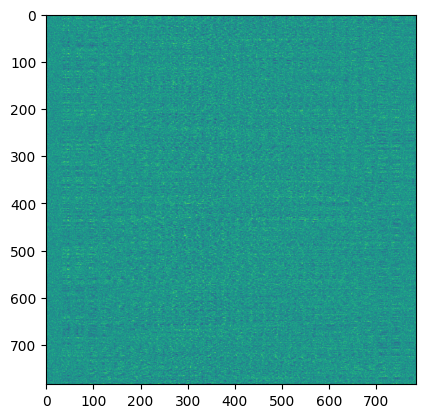

In [25]:
plt.imshow(net.lif1.recurrent.weight.data.cpu().numpy())
plt.show()

#### Optimisation metrics

In [26]:
loss = nn.L1Loss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

#### Training loop

In [31]:
def mkdir(path):
    if not os.path.exists(path): os.makedirs(path)
    return path

def save_state(path):
    weights_save_file = f'snntorch_model_state_epoch_{epoch}_{datetime.datetime.now().strftime("%d-%m-%YT%H-%M")}.pth'
    state = {
        'epochs': num_epochs,
        'model_state': net.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'loss_hist': loss_hist
    }
    torch.save(state, mkdir(path)/weights_save_file)

In [32]:
# TRAINING LOOP

num_epochs = 20
loss_hist = []
counter = 0

batch_loss = 0

for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)
    
    # Minibatch training loop
    for data in tqdm(train_batch, f'Epoch {epoch} Loss {batch_loss}'):
    
        data = data.to(device)

        # forward pass
        # net.train()
        spk_rec, mem_rec = net(data)

        # initialise the loss and sum over time
        # loss_val = torch.zeros((1), dtype=dtype, device=device) # TRY THIS APPROACH AFTER
        # for step in range(num_steps):
        #     loss_val += loss(mem_rec[step], targets)
        batch_loss = loss(mem_rec, torch.zeros_like(mem_rec)) # preactivation loss
        # batch_loss = loss(spk_rec, torch.zeros_like(mem_rec)) # postactivation loss

        # gradient calculation and weight update
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        loss_hist.append(batch_loss.item())
    save_state(weights_save_path)

Epoch 2 Loss 0.0597771592438221:  45%|████▌     | 169/375 [00:21<00:25,  7.93it/s]


KeyboardInterrupt: 

In [ ]:
weights_load_base_path = Path.home() / 'RANCZLAB-NAS/iakov/produced/1000x1000_matrix_class_pretrained_subtract_reset_beta_0.95'
weights_filename = 'snntorch_model_state_07-02-2024T17-52.pth'

weights_load_path = weights_load_base_path / weights_filename
checkpoint = torch.load(weights_load_path)
net.load_state_dict(checkpoint['model_state'])
optimizer.load_state_dict(checkpoint['optimizer_state'])
num_epochs = checkpoint['epochs']
loss_hist = checkpoint['loss_hist']
print(f'Loaded weights with {num_epochs} epochs from {weights_load_path}')

In [ ]:
# %matplotlib widget
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
# plt.xlim([0,1700])
# plt.savefig()
plt.show()

In [ ]:
plt.figure()
plt.imshow(net.lif1.recurrent.weight.data.cpu().numpy())
plt.show()

#### Looking at network dynamics

In [ ]:
mem_rec.shape

In [ ]:
random_data.shape

In [ ]:
net.eval()

random_data = next(iter(train_loader)).to(device)
spk_rec, mem_rec = net(random_data)

dim_size = int(LIF_linear_features**0.5)


arr1 = random_data[:,:,:].reshape((batch_size,batch_data_shape[1],dim_size,dim_size)).detach().cpu().numpy()[0,:,:,:]
arr2 = mem_rec.reshape((batch_size,batch_data_shape[1],dim_size,dim_size)).detach().cpu().numpy()[0,:,:,:]
arr3 = spk_rec.reshape((batch_size,batch_data_shape[1],dim_size,dim_size)).detach().cpu().numpy()[0,:,:,:]

In [ ]:
# Animation takes long time to load
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()

fig, ax = plt.subplots(nrows=1,ncols=3)

def animate(t):
    plt.cla()
    ax[0].set_title(f'Frame {t}: input', fontsize=5)
    ax[0].imshow(arr1[t,:,:])
    ax[1].set_title(f'Frame {t}: membrane voltage', fontsize=5)
    ax[1].imshow(arr2[t,:,:])
    ax[2].set_title(f'Frame {t}: unit spiking', fontsize=5)
    ax[2].imshow(arr3[t,:,:])

anim = matplotlib.animation.FuncAnimation(fig, animate, frames=batch_data_shape[1])
anim
# writervideo = matplotlib.animation.ImageMagickWriter(fps=60) 
# anim.save(f'{weights_filename}_movie.gif') 
# plt.close() 

In [ ]:
mem_rec.shape

In [ ]:
plt.figure()
plt.plot(mem_rec[0,:,300].detach().cpu().numpy())
plt.show()

In [ ]:
plt.figure()
plt.plot(spk_rec[0,:,300].detach().cpu().numpy())
plt.show()

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(mem_rec[0].detach().cpu().numpy())
print(pca.explained_variance_ratio_)
comps = pca.transform(mem_rec[0].detach().cpu().numpy())
print(comps.shape)

In [ ]:
plt.figure()
plt.scatter(np.arange(batch_data_shape[1]), comps[:,0])
plt.show()

In [ ]:
mem_rec[0].shape